# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

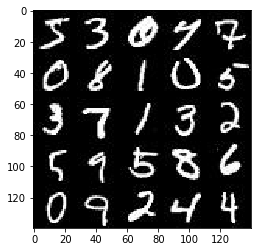

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

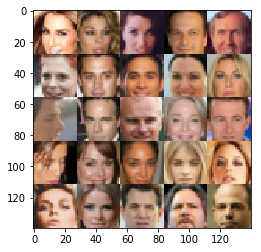

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
    z_input =  tf.placeholder(tf.float32, shape=[None, z_dim], name='z_input')
    learning_rate =  tf.placeholder(tf.float32, shape=[], name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
                
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(x1)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # for sample generation
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # map images for [-0.5,0.5] to [-1,1]
                batch_images = batch_images * 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images=30, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2106... Generator Loss: 2.3606
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 14.0546
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 15.1053
Epoch 1/2... Discriminator Loss: 0.1906... Generator Loss: 7.9816
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 0.1810... Generator Loss: 8.6092
Epoch 1/2... Discriminator Loss: 0.0720... Generator Loss: 5.0087
Epoch 1/2... Discriminator Loss: 0.4587... Generator Loss: 11.8567
Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 2.6327
Epoch 1/2... Discriminator Loss: 0.2503... Generator Loss: 2.5668


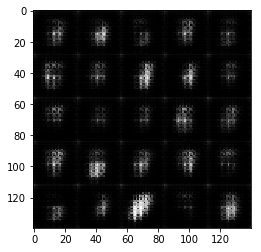

Epoch 1/2... Discriminator Loss: 0.1630... Generator Loss: 4.1189
Epoch 1/2... Discriminator Loss: 0.2880... Generator Loss: 2.8487
Epoch 1/2... Discriminator Loss: 0.1864... Generator Loss: 2.8782
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 4.6818
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.7427
Epoch 1/2... Discriminator Loss: 0.2226... Generator Loss: 5.3980
Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 3.9769
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 2.6301
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.6163
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 1.3537


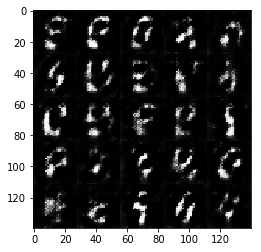

Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 2.0524
Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.4894
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.6253
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 0.6340... Generator Loss: 1.2056
Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 2.5173
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.3413


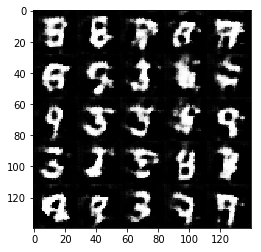

Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 2.6153
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 2.7260
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 2.6430
Epoch 1/2... Discriminator Loss: 2.1308... Generator Loss: 0.1920
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 2.2888
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.2800
Epoch 1/2... Discriminator Loss: 1.6233... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 0.9625


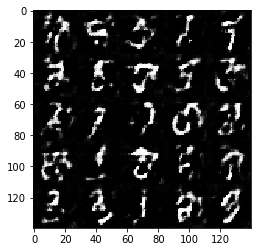

Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.5831
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.5702... Generator Loss: 1.9812
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 2.5172
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 1.3253
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.6771
Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 1.8095


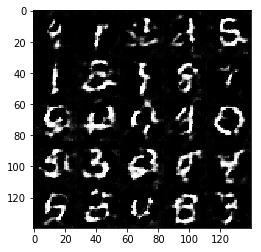

Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 0.6351... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.8486
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 1.3302
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 2.3906
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 0.8944


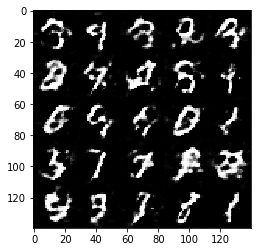

Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.7366... Generator Loss: 2.0332
Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 1.8544
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.0245
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.7980


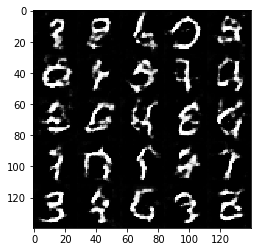

Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.4909
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 2.6022
Epoch 1/2... Discriminator Loss: 0.7308... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 1.6474
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 1.3048
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.1228
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.0829


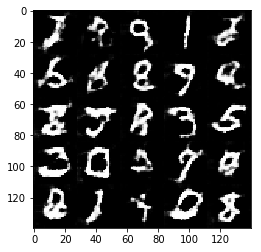

Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.2164
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 0.5274... Generator Loss: 2.0423
Epoch 1/2... Discriminator Loss: 0.5922... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 1.3450
Epoch 1/2... Discriminator Loss: 0.7729... Generator Loss: 1.9698
Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 1.5049


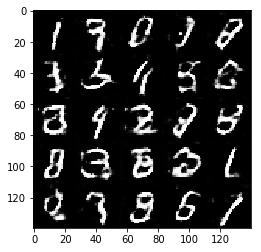

Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 1.3665
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.6224
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.1803
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.1857
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.7243
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.6036
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.2458


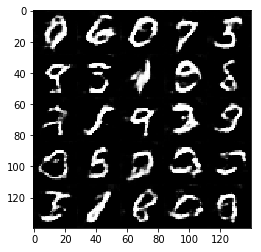

Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.5048
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.7628
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.5572


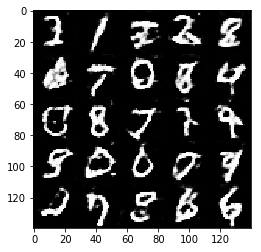

Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.4138
Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 2.2767
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.1172
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.5585
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.3436


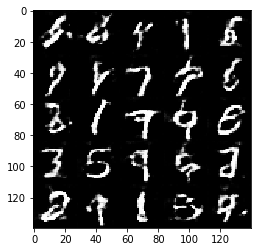

Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.3526
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.9675
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.2616
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.3355


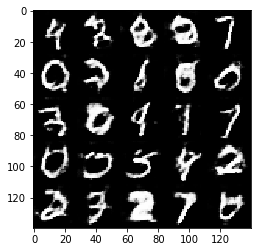

Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.4227
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 1.8022
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.0179
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 3.5981


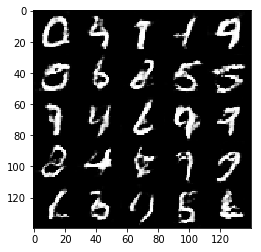

Epoch 2/2... Discriminator Loss: 1.4740... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 3.2846
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.2805
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.6227... Generator Loss: 0.3272
Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.1586
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.3889


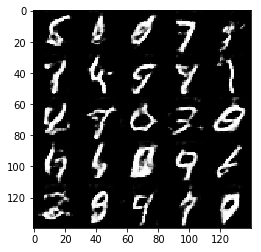

Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.6581... Generator Loss: 1.1669
Epoch 2/2... Discriminator Loss: 0.3581... Generator Loss: 2.4151
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.5591
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.0966
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 1.0019


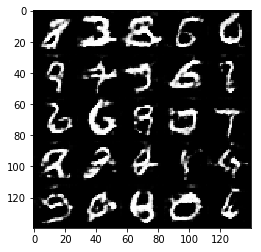

Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 1.9741... Generator Loss: 4.7228
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 0.4511... Generator Loss: 1.5440
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 0.5628... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.0136
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.3719


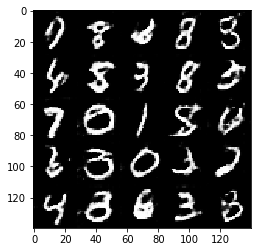

Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.1698
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.6276
Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 1.7439
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.5650


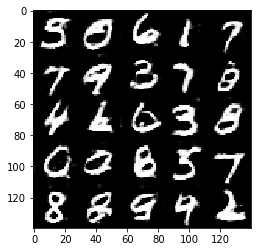

Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 2.5861
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 0.9468


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.5967... Generator Loss: 0.0022
Epoch 1/1... Discriminator Loss: 0.1555... Generator Loss: 11.3704
Epoch 1/1... Discriminator Loss: 1.6215... Generator Loss: 19.3298
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 15.5036
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 13.8813
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.1624
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 4.5150
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 1.7965
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.1804


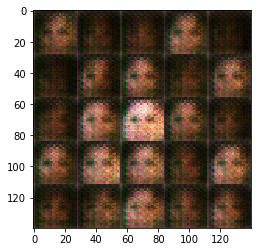

Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 3.6956
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 2.1627
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 1.7848
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 3.5825
Epoch 1/1... Discriminator Loss: 2.1306... Generator Loss: 5.8494
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.0773


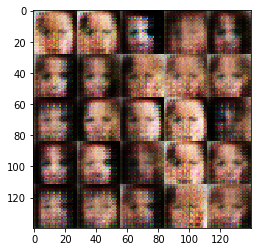

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 3.0147
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.4693
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.0321


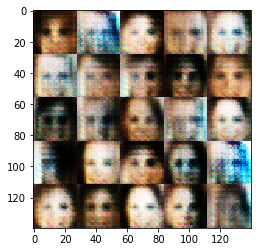

Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 3.6042
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.7424
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 4.1132
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.2673
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.4057


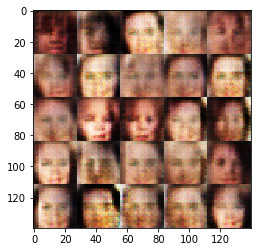

Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 3.0467
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 1.5469
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 2.9212
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9010


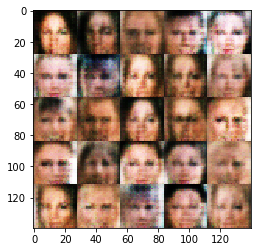

Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.5796
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 3.4237
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9109


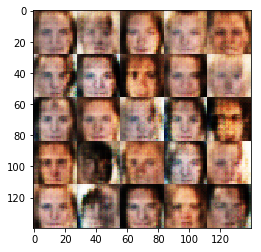

Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 2.1468
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.8846
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7169


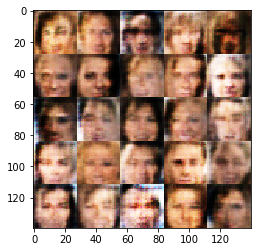

Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 2.1860
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.9313


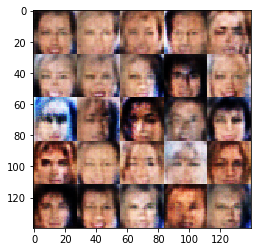

Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 2.5819
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.5027
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.9545... Generator Loss: 0.2566
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.3355


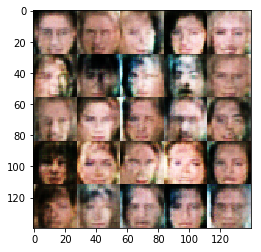

Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 2.1286
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 0.2564
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.7932
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 2.0010
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.1483


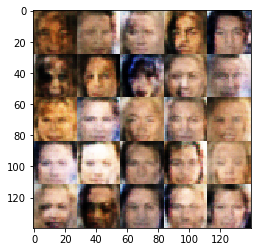

Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 2.2527
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 2.6640


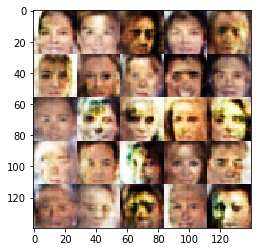

Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.9605
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 2.2723
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 2.0971
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.7439


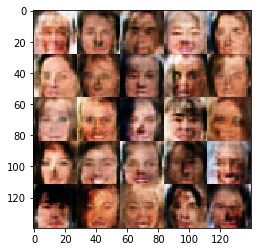

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.7117


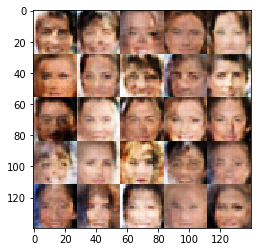

Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.9412
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.5488
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 2.3459


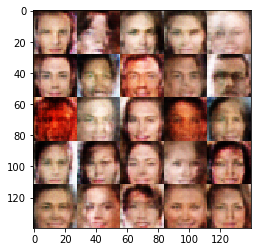

Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 3.0246
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 0.9397


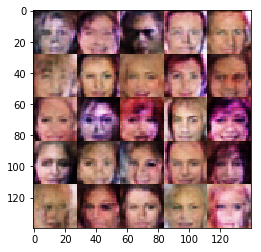

Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.3699
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.9548


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.